In [1]:
# from pyeeg.connectivity import phase_transfer_entropy
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import pandas as pd

In [2]:
fs = 100
t = np.arange(0, 10, 1/fs)
x = np.random.randn(len(t), 1)
low_pass = sig.firwin(101, 10, fs=fs) # 10 Hz low pass filter
x = sig.filtfilt(low_pass, 1, x, axis=0)

In [3]:
plt.style.use('my_dark')

(0.0, 50.0)

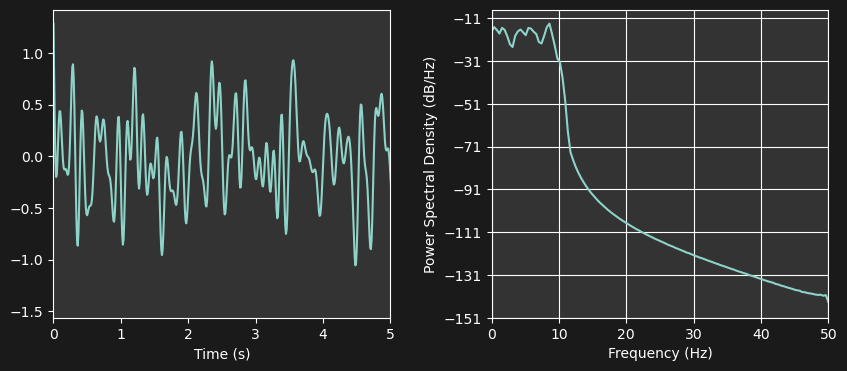

In [4]:
f, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
ax[0].plot(t, x)
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim([0, 5])

ax[1].psd(x.squeeze(), Fs=fs) # power spectral density
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_xlim([0, 50])

In [5]:
phi_x = np.angle(sig.hilbert(x, axis=0)) # between -pi and pi

(0.0, 5.0)

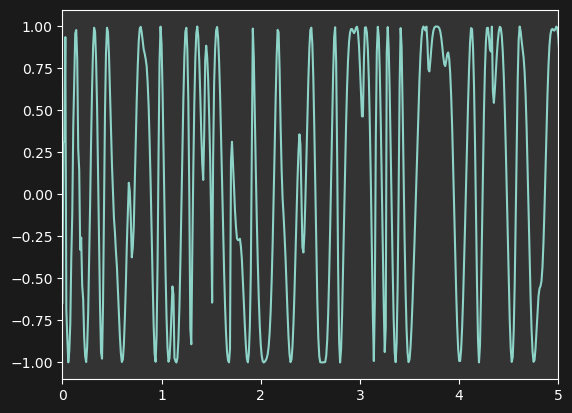

In [6]:
plt.plot(t, np.sin(phi_x))
plt.xlim([0, 5])

In [731]:
from scipy.fftpack import fft, fftfreq

## Phase transfer entropy

In [744]:
phi.shape

NameError: name 'phi' is not defined

In [786]:
data = simulate_var(1, coef, 1000, 2)
print(data.shape)
data = sig.filtfilt(low_pass, 1, data, axis=0)

N, K = data.shape
PTE = np.zeros((K, K))
dPTE = np.zeros((K, K))

analytical_sig = sig.hilbert(data, axis=0)
phi = np.angle(analytical_sig)

# Compute ideal delay
count1, count2 = 0, 0
for j in range(K):
    for i in range(1, N-1):
        count1 += 1
        if (phi[i-1, j] * phi[i+1, j]) < 0:
            count2 += 1
print(np.round(count1/count2))
delay = int(np.round(count1/count2))

phi += np.pi # get it between 0 and 2pi

# Binsize
method = 'fd'
if method=='scott':
    binsize = 3.49*np.std(phi, 0).mean()/np.power(N, 1/3) # binsize as in Scott et al. 2014
elif method=='fd':
    binsize = 2*(np.percentile(phi, 75) - np.percentile(phi, 25))*np.power(N, -1/3) # binsize as in Freedman et al. 1981
elif method=='otnes':
    # binsize based on Otnes R. and Enochson (1972) Digital Time Series Analysis. Wiley.
    # as in Brainwave (C.J. Stam)
    # Nbins = np.round(np.log2(N)) + 1
    Nbins = np.exp(0.626 + 0.4*np.log(N-(delay+1)))
    binsize = 2*np.pi/Nbins

# get the bins
bins_w = np.arange(0, 2*np.pi, binsize)
Nbins = len(bins_w)

(1000, 2)
5.0


In [788]:
bins_w

array([0.        , 0.73391991, 1.46783981, 2.20175972, 2.93567962,
       3.66959953, 4.40351943, 5.13743934, 5.87135925])

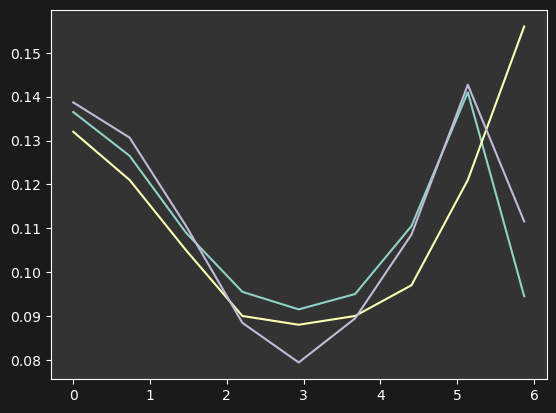

In [800]:
Py = np.histogram(phi, np.r_[bins_w, 2*np.pi])[0]
plt.plot(bins_w, Py/np.sum(Py))

Py = np.histogram(phi, bins=Nbins, range=[0, 2*np.pi])[0]
plt.plot(bins_w, Py/np.sum(Py))

# Matlab code
Py = np.zeros((Nbins, 1))
for k in range(N-delay):
    Py[rn_y[k]] += 1
plt.plot(bins_w, Py/(N-delay))

In [797]:
rn_ypr = np.ceil(phi[delay:, 0]/binsize).astype(int) # bin number for each sample (history)
rn_y = (np.ceil(phi[:-delay, 0]/binsize)).astype(int) -1 # bin number for each sample (current)
rn_x = np.ceil(phi[:-delay, 1]/binsize).astype(int) # bin number for each sample (current)

In [ ]:
for i in range(K):
    for j in range(K):
        if i==j: continue
        Py = np.histogram(phi[:, i], bins=np.arange(-np.pi, np.pi+binsize, binsize))[0]
        # Compute phase transfer entropy


## Granger Causality

Focusing on:
1. Granger causality defined from autoregressive methods (see [Cohen's video](https://www.youtube.com/watch?v=XqsSB_vpHLs))
2. Compared to spectral measures such as magnitude coherence between both signals

First I need to produce two signals from a VAR model:
- I will either generate one $X\approx$ AR(2)/ or $\approx \mathcal{N}(0, 1)$ signal, and bind a second signal to it such as e.g. $Y(t) = 1.2 X(t-1) - 0.9 X(t-2)$
- or directly generate a _pair_ of signals with a VAR(2) model

Given the univariate process:
$$
x(t) = a_1 x(t-1) + a_2 x(t-2) + \cdots + e_{x}(t)
$$
And the bivariate process:
$$
x(t) = a_1 x(t-1) + a_2 x(t-2) + \cdots + b_1 y(t-1) + b_2 y(t-2) + \cdots +  \epsilon_{xy}(t)
$$

We can get the granger causality measure as:
$$
GC = log(\frac{var(e)}{var(\epsilon)})
$$

In [649]:
import statsmodels.tsa.api as smt

def simulate_ar(order, coefs, n, sigma=1, seed=42):
    """
    Simulate an autoregressive process of order `order`.

    Parameters
    ----------
    order : int
        The order of the autoregressive process.
    coefs : array_like
        The coefficients of the autoregressive process. The first element is the coefficient of the lag (t-1).
    n : int
        The number of samples to simulate.
    sigma : float
        The standard deviation of the additive noise process.
    
    Returns
    -------
    x : array_like
        The simulated time series. Shape (n,).
    """
    rng = np.random.default_rng(seed)
    x = np.zeros(n + order)
    for i in range(n+order):
        if i < order:
            x[i] = rng.standard_normal()* sigma
        else:
            x[i] = np.dot(coefs[::-1], x[i-order:i]) + rng.standard_normal()*sigma
    return x[order:]

# Function to simulate VAR model
def simulate_var(order, coef, nobs=500, ndim=2, seed=42, verbose=False):
    """
    Simulate a VAR model of order `order`.

    The VAR model is defined as:

    .. math::
        x_t = A_1 x_{t-1} + A_2 x_{t-2} + ... + A_p x_{t-p} + \\epsilon_t
        x_t = \\sum_{i=1}^p A_i x_{t-i} + \\epsilon_t

    where :math:`x_t` is a vector of shape (ndim, 1), :math:`A_i` is a matrix of shape (ndim, ndim)

    .. note::
        The coefficients at a given lag are such as :math:`C_ij` is i->j, so it will be the coefficients for dimension j!
        For example, each row of the first column are determining the contributions of each component onto the first component.
    """
    rng = np.random.default_rng(seed)
    if order == 1 and coef.ndim == 2:
        coef = coef[None, :, :]
    assert coef.shape == (order, ndim, ndim), "coef must be of shape (order, ndim, ndim)"
    data = np.zeros((nobs+order, ndim))

    if verbose:
        print(f"Simulating VAR({order}) model with {ndim} dimensions and {nobs} observations")
        print(f"Data shape: {data.shape}")

    data[:, :] = rng.standard_normal(size=data.shape) # initialize with noise
    for t in range(order, nobs+order):
        for lag in range(order):
            data[t] += data[t-(lag+1)] @ coef[lag] # here if I multiply from the left, I get the contributions row wise instead of column wise

    return data[order:, :]

# Quick test, both implementation give the same result:
# x1 = simulate_ar(2, [1.2, -0.8], 500)
# x2 = simulate_var(2, np.asarray([1.2, -0.8])[:, None, None], 500, ndim=1)
# np.allclose(x1, x2[:, 0]) # True

def fit_ar(x, nlags=1, time_axis=0):
    """
    Fit an autoregressive model to a time series.
    This is a helper function for autoregressive models estimation.

    If fed with a multidimensional time series, it will fit a model for each
    dimension.
    """
    if x.ndim == 1:
        time_axis = 1
    x = np.atleast_2d(x)
    if time_axis == 1: # transpose if time is in columns
        x = x.T
    n, k = x.shape # n: number of observations, k: number of dimensions

    X = design_lagmatrix(x, nlags=nlags, time_axis=0) # time axis was already transposed
    if k == 1:
        X = np.atleast_3d(X)
    Y = x[nlags:, :]

    betas = np.zeros((k, nlags))
    for i in range(k):
        betas[i] = np.linalg.lstsq(X[:, :, i], Y[:, i], rcond=None)[0]
    return betas.squeeze() if k==1 else betas

def fit_var(x, nlags=1, time_axis=0):
    """
    Fit a VAR model to a time series.

    Instead of fitting k independent models as in `fit_ar`, this function fits a single model
    but with multivariate regressors.
    """
    if x.ndim == 1:
        time_axis = 1
    x = np.atleast_2d(x)
    if time_axis == 1: # transpose if time is in columns
        x = x.T
    n, k = x.shape # n: number of observations, k: number of dimensions

    X = design_lagmatrix(x, nlags=nlags, time_axis=0) # time axis was already transposed
    if k == 1:
        X = np.atleast_3d(X)
    Y = x[nlags:, :]
    # Now instead of looping over thrid axies of X (dimensions), we reshape it to a 2D matrix
    # And fit a single model
    betas = np.linalg.lstsq(X.reshape(-1, nlags*k), Y, rcond=None)[0]
    return betas.reshape(k, nlags, k)#.transpose(2, 1, 0) # reshape back to 3D

def design_lagmatrix(x, nlags=1, time_axis=0):
    """
    Design a matrix of lagged time series.
    This is a helper function for autoregressive models estimation (so it will design a matrix of its own signal
    and will not use lag 0, only negative lag, i.e. to use for AR models and not ARMA).
    """
    if x.ndim == 1:
        time_axis = 1
    x = np.atleast_2d(x)
    if time_axis == 1: # transpose if time is in columns
        x = x.T
    n, k = x.shape # n: number of observations, k: number of dimensions
    X = np.zeros((n-nlags, nlags, k))
    for i in range(nlags):
        # X[:, i, :] = x[i+1:n-nlags+i+1]
        X[:, i, :] = np.roll(x, (i+1), axis=0)[nlags:, :]
    return X.squeeze(-1) if k==1 else X

def granger_causality(X, nlags=1, time_axis=0, verbose=False):
    """
    Compute the Granger causality matrix of a multivariate time series.

    TODO: now apparently I am computing whether all signals are causing each other, but I should compute
    whether each signal is causing the others, so I should loop over the dimensions and compute the GC
    for each pair of signals??....
    """
    if time_axis == 1:
        X = X.T
    n, k = X.shape # n: number of observations, k: number of channels
    if verbose:
        print(f"Fitting AR({nlags}) model for each {k} channels and one VAR({nlags}) model with {k} channels")
    # Fit AR to every single time series
    beta_single = fit_ar(X, nlags=nlags, time_axis=0)
    # Fit VAR to the multivariate time series
    beta_multi = fit_var(X, nlags=nlags, time_axis=0)

    # This is redundant, as it's calculated already twice in the function above
    # TODO: if necessary, rewrite the function to avoid this
    Xlagged = design_lagmatrix(X, nlags=nlags, time_axis=0)
    # Compute the residuals
    if verbose: print("Computing residuals")
    residuals_single = []
    for c in range(k):
        residuals_single.append(X[nlags:, c] - Xlagged[..., c] @ beta_single[c])
    residuals_single = np.asarray(residuals_single).T
    residuals_multi = X[nlags:, :] - Xlagged.reshape(-1, nlags*k) @ beta_multi.reshape(nlags*k, k)

    GC = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            if i != j:
                # np.log(np.var(ex)/np.var(exy[:, 0])), np.log(np.var(ey)/np.var(exy[:, 1]))
                GC[i, j] = np.log(np.var(residuals_single[:, j]) / np.var(residuals_multi[:, j]))
    return GC


def log_likelihood_lm(y, X, beta):
    """
    Compute the log likelihood of a linear model given the data and the parameters.

    Parameters
    ----------
    y : array_like
        The dependent variable. Shape (n, k), with n number of samples.
    X : array_like
        The independent variables. Shape (n, p), with p number of predictors.
    beta : array_like
        The parameters of the model. Shape (p, k), with k number of dependent variables.

    """
    n = len(y)
    residuals = y - X @ beta
    if y.ndim ==1:
        sigma2 = np.var(residuals, axis=0)
        log_likelihood = -n/2 * np.log(2*np.pi) - n/2 * np.log(sigma2) - 1/(2*sigma2) * np.sum(residuals.T @ residuals, axis=0)
    else:
        sigma_hat = np.cov(residuals.T)  # Covariance matrix
        # Multivariate normal log-likelihood
        log_likelihood = -n/2 * np.log(np.linalg.det(sigma_hat)) - 1/2 * np.trace(np.linalg.inv(sigma_hat) @ (residuals.T @ residuals))
    return log_likelihood

In [ ]:
X = design_lagmatrix(x, nlags=2)
%timeit beta = np.linalg.lstsq(X, x[2:, None], rcond=None)[0]
%timeit beta2 = smt.AutoReg(np.c_[x], 2, 'n').fit().params[:]

beta = beta.squeeze()
beta2 = beta2.squeeze()
data = {'Hand-Built AutoReg': beta, 'Statsmodel AutoReg': beta2}
df = pd.DataFrame(data, index=[f'Coefficient {i}' for i in range(len(beta))])

df

35.2 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.9 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Hand-Built AutoReg,Statsmodel AutoReg
Coefficient 0,1.207431,1.207431
Coefficient 1,-0.827280,-0.827280


In [232]:
X = design_lagmatrix(x, nlags=2, time_axis=0)

The results are indeed identical to the ones obtained with the `statsmodels` package. However I did manage to get to this result roughly **60 times** faster!

(0.0, 5.0)

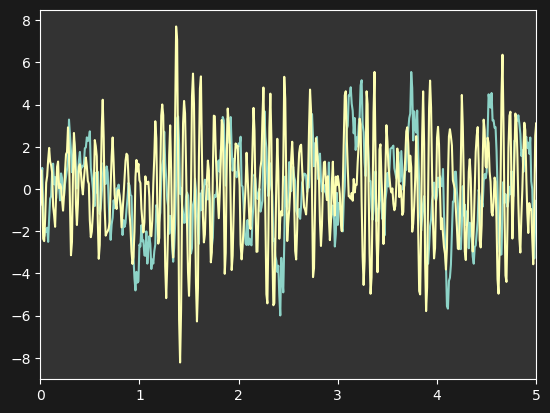

In [393]:
# Example
order = 1
a = np.array([0.9])
n = len(t)
x1 = simulate_ar(order, a, n)
order = 2
a = np.array([1.2, -0.8])
x2 = simulate_ar(order, a, n)
plt.plot(t, x1)
plt.plot(t, x2)
plt.xlim([0, 5])

And we can check that our implementations of `simulate_var` and `fit_var` all work correctly. Indeed we obtain the same results than with fitting methods from `statsmodels` package, albeit with a much faster computation time.

> Note that the order of dimensions in the `statsmodels` package is reversed compared to our implementation. Namely the coefficients are stored in the opposite order, in our implementation the coefficients for $x_2$ are stored in the second column (instead of second _row_). Although the lag dimension is also the first.

In [418]:
fit_var(np.c_[x, y], nlags=2) # much faster again! 16x faster than statsmodels
model.fit(maxlags=2, trend='n').coefs.swapaxes(1, 2) # same as above

array([[[ 1.25723693,  1.07127231],
        [-0.04828006,  0.01212434]],

       [[-0.83072654, -0.6232223 ],
        [ 0.01959252, -0.01495698]]])

In [646]:
x = x2
y = np.random.randn(len(t),)
a = [1.05, -0.6]
for k, aa in enumerate(a): # len(a) = order
    y[k+1:] += aa * x[:-k-1] # x[t-k-1]

# Fit AR model
model = smt.AutoReg(np.c_[x], 2)
results = model.fit()
ex = results.resid

# Fit AR model
model = smt.AutoReg(np.c_[y], 2)
results = model.fit()
ey = results.resid

# Fit VAR model
model = smt.VAR(np.c_[x, y])
results = model.fit(maxlags=2)
epsxy = results.resid

In [446]:
GC_xy = np.log(np.var(ey)/np.var(epsxy[:, 1]))
GC_yx = np.log(np.var(ex)/np.var(epsxy[:, 0]))

print(GC_xy, GC_yx)

1.1252232848089543 0.0011730722827643987


In [436]:
# We can do the same with our own functions:
betas = fit_ar(np.c_[x, y], nlags=2) # we can put both signals at once two fit two models in one go
ex = x[2:] - design_lagmatrix(x, nlags=2) @ betas[0]
ey = y[2:] - design_lagmatrix(y, nlags=2) @ betas[1]

betas = fit_var(np.c_[x, y], nlags=2)
# exy = np.c_[x, y][2:] - design_lagmatrix(np.c_[x, y], nlags=2) @ betas
exy = np.c_[x, y][2:] - design_lagmatrix(np.c_[x, y], nlags=2).reshape(-1, 4) @ betas.reshape(4, 2)

array([[0.        , 0.95925657],
       [0.0067969 , 0.        ]])

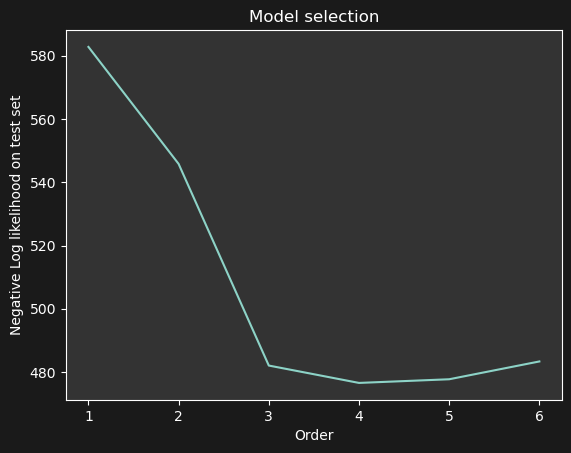

In [673]:
a = np.array([1.2, -0.8, 0.4])
x = simulate_ar(3, a, n)
y = np.random.randn(len(t),)
a = [1.05, -0.6, 0.3]
for k, aa in enumerate(a): # len(a) = order
    y[k+1:] += aa * x[:-k-1] # x[t-k-1]

LLS = []
for l in np.arange(1, 7):
    Xtrain = design_lagmatrix(np.c_[x[:n//2], y[:n//2]], nlags=l)
    b = fit_var(np.c_[x[:n//2], y[:n//2]], nlags=l)
    Xtest = design_lagmatrix(np.c_[x[n//2:], y[n//2:]], nlags=l)
    LLS.append(-log_likelihood_lm(np.c_[x[n//2:], y[n//2:]][l:], Xtest.reshape(-1, l*2), b.reshape(l*2, 2)))
plt.plot(np.arange(1, 7), LLS)
plt.xlabel('Order')
plt.ylabel('Negative Log likelihood on test set')
plt.title('Model selection')
granger_causality(np.c_[x, y], nlags=3)

In [468]:
print(np.log(np.var(ex)/np.var(exy[:, 0])), np.log(np.var(ey)/np.var(exy[:, 1])))
print(np.log(np.var(ex)/np.var(exy[:, 1])), np.log(np.var(ey)/np.var(exy[:, 0])))

0.0011630312354800887 1.125168700563013
-0.00406996941588297 1.1304017012143763


In [318]:
nobs = 1000
order = 1
coef = np.diag(np.array([0.8, -0.4])) # as such the coefficients will only influence themselves
coef = np.array([[0.8, -0.2],
                 [0.5, -0.4]])

# Generate data
data = simulate_var(order, coef, nobs, verbose=True)

Simulating VAR(1) model with 2 dimensions and 1000 observations
Data shape: (1000, 2)
True
False


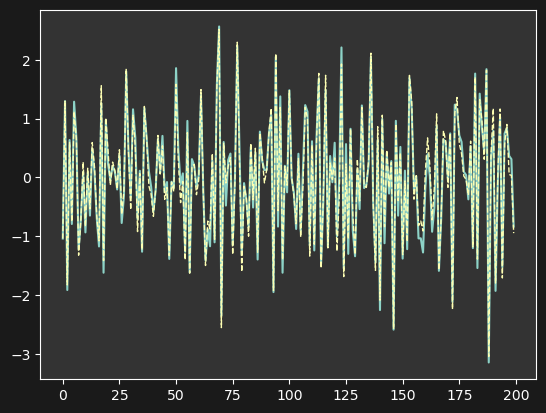

In [299]:
plt.plot(data[:200, 1])

In [300]:
# Define parameters
nobs = 1000
order = 1
coef = np.diag(np.array([0.8, -0.4])) # as such the coefficients will only influence themselves
coef = np.array([[0.8, -0.2],
                 [0.5, -0.4]])

# Generate data
data = simulate_var(order, coef, nobs)

# Fit VAR model
model = smt.VAR(data)
results = model.fit(maxlags=order)

# Print model summary
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Nov, 2023
Time:                     13:10:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0429121
Nobs:                     999.000    HQIC:                 0.0246433
Log likelihood:          -2835.75    FPE:                    1.01353
AIC:                    0.0134421    Det(Omega_mle):         1.00747
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.065970         0.031972           -2.063           0.039
L1.y1         0.819524         0.019528           41.967           0.000
L1.y2         0.524012         0.028834           18.174           0.000

Results for equation 

In [301]:
print(results.coefs) # coefs
#results.resid_acov(2)
results.resid.shape # residual for each time series (epsilon as we doing a multivariate regression)

[[[ 0.81952445  0.52401185]
  [-0.21859372 -0.400867  ]]]


(999, 2)

In [320]:
results.resid_acov(0), results.resid_corr

(array([[[0.98124527, 0.05824476],
         [0.05824476, 1.024029  ]]]),
 array([[1.        , 0.05810479],
        [0.05810479, 1.        ]]))

In [303]:
results.test_causality(1, 0, kind='f').summary()

Test statistic,Critical value,p-value,df
120.1,3.846,0.000,"(1, 1992)"


In [689]:
np.stack([coef, coef/2.])

array([[[ 0.8 , -0.2 ],
        [ 0.5 , -0.4 ]],

       [[ 0.4 , -0.1 ],
        [ 0.25, -0.2 ]]])

In [717]:
granger_test.conclusion_str

'Conclusion: reject H_0'

Simulating VAR(2) model with 2 dimensions and 1000 observations
Data shape: (1002, 2)
1 -> 2 Conclusion: fail to reject H_0
2 -> 1 Conclusion: reject H_0
[[0.         0.00247779]
 [0.35849558 0.        ]]


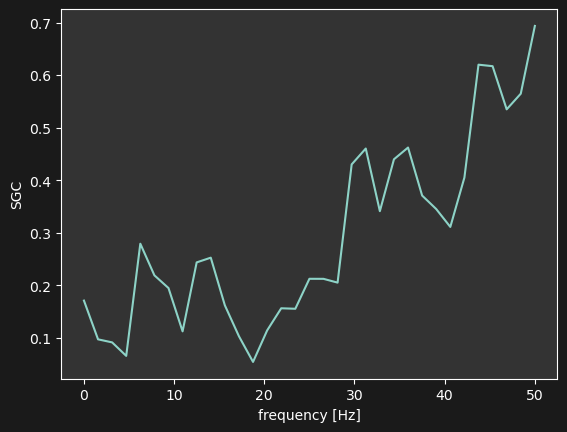

In [726]:
# data = np.c_[x, y]
coef = np.array([[0.8, -0.002],
                 [0.5, -0.4]])

# Generate data
data = simulate_var(2, np.stack([coef, -coef/4.2]), nobs, verbose=True)

# Fit VAR model
model = smt.VAR(data)
results = model.fit(maxlags=1)
# Test for Granger Causality
# granger_test = results.test_causality('y', 'x', kind='f')
granger_test = results.test_causality(1, 0, kind='f')
print("1 -> 2 " + granger_test.conclusion_str)
granger_test = results.test_causality(0, 1, kind='f')
print("2 -> 1 " + granger_test.conclusion_str)
print(granger_causality(data, nlags=2))

# Assume x and y are your time series data
x, y = data.T
nfft = 64
f, Pxx = sig.welch(x, nperseg=nfft, window='hann', fs=fs, scaling='spectrum')
# f, Pxx = sig.csd(x, x, fs=fs)
_, Pyy = sig.welch(y, nperseg=nfft, window='hann', fs=fs, scaling='spectrum')
# _, Pyy = sig.csd(y, y)
f2, Pxy = sig.csd(x, y,nperseg=nfft, scaling='spectrum')


# Compute spectral Granger causality
SGC = np.abs(Pxy)**2 / (Pxx * Pyy)

# Plot spectral Granger causality
# plt.semilogy(f, SGC)
plt.plot(f, SGC)
plt.xlabel('frequency [Hz]')
plt.ylabel('SGC')
plt.show()

## A quick simulation on how TRF influence over explained variance

Depending on width of TRF and variance of feature signals.

In [632]:
from pyeeg.models import TRFEstimator

# Create some simulated TRF
fs = 100
t = np.arange(0, 10, 1/fs)
low_pass = sig.firwin(101, 10, fs=fs) # 10 Hz low pass filter
tmin = -0.5
tmax = 0.5
tlags = np.arange(tmin, tmax, 1/fs)
trf2 = np.exp(-(tlags - 0.2)**2/0.05**2) * 2.

var_second = np.arange(0.2, 2.3, 0.1)
spread = np.arange(0.05, 0.6, 0.04)
r2_from1 = np.zeros((len(var_second), len(spread)))
r2_from2 = np.zeros((len(var_second), len(spread)))
ratios = np.zeros((len(spread),1))
for kv, v in enumerate(var_second):
    x = np.random.randn(len(t), 2) @ np.diag([1, v]) # two envelopes, one has larger variance
    x = sig.filtfilt(low_pass, 1, x, axis=0)
    for ks, s in enumerate(spread):
        trf1 = np.exp(-(tlags - 0.1)**2/s**2)
        # plt.plot(tlags, trf, label=f"var={v}, spread={s}")
    
        # print("Variances:")
        # print(np.var(x, axis=0))
        # print("TRF integrals:")
        # print(trf1.sum(), trf2.sum())
        ratios[ks] = (trf1**2).sum()/ (trf2**2).sum()

        y = sig.convolve(x[:, 0], trf1, mode='same')
        y += sig.convolve(x[:, 1], trf2, mode='same')
        y += np.random.randn(len(t)) * 0.1
        total_var = np.var(y)

        trf = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=30, verbose=False)
        xz = (x - x.mean(0))/x.std(0)
        trf.fit(xz, y[:, None])

        # trf.fit(xz[:, [0]], y[:, None])
        yhat = trf[0].predict(xz[:, [0]])
        residual_var = np.var(y - yhat.squeeze())
        r2 = 1 - residual_var/total_var
        r2_from1[kv, ks] = r2
        # print(f"R2: {r2}")

        # trf.fit(xz[:, [1]], y[:, None])
        yhat = trf[1].predict(xz[:, [1]])
        residual_var = np.var(y - yhat.squeeze())
        r2 = 1 - residual_var/total_var
        r2_from2[kv, ks] = r2
        # print(f"R2: {r2}")

INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...


INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg:Creating lagged feature matrix...
INFO:pyeeg

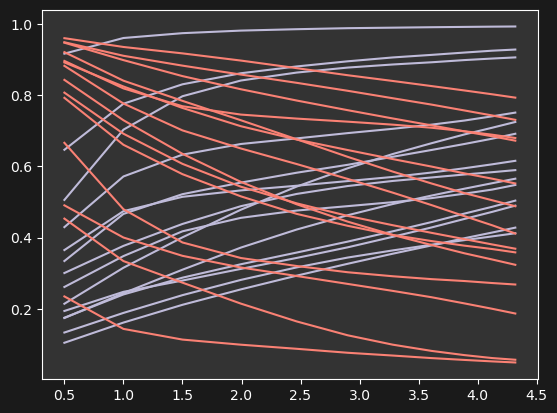

In [625]:
plt.plot(ratios, r2_from1.T, 'C2')
plt.plot(ratios, r2_from2.T, 'C3')

(21, 14)


Text(0, 0.5, 'Ratio of second regressor to first regressor var')

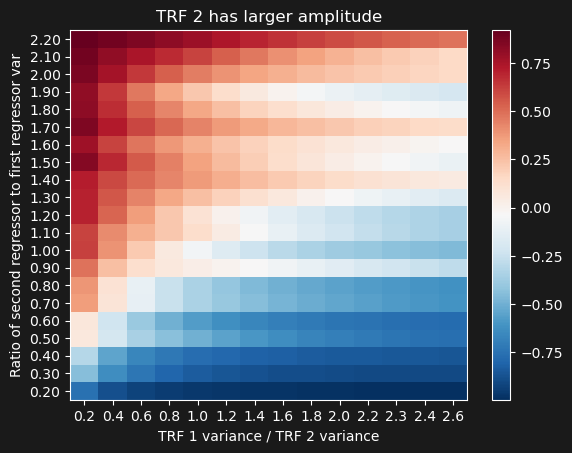

In [633]:
print(r2_from2.shape)
plt.imshow(r2_from2-r2_from1, aspect='auto', origin='lower', cmap='RdBu_r')
plt.yticks(range(len(var_second)), [f"{r:.2f}" for r in  var_second])
plt.xticks(range(len(spread)), [f"{r:.1f}" for r in ratios.squeeze()])
plt.colorbar()
plt.title('TRF 2 has larger amplitude')
plt.xlabel('TRF 1 variance / TRF 2 variance')
plt.ylabel('Ratio of second regressor to first regressor var')